In [5]:
###################################################################################
# Calculate emissions in North China Plain (NCP) using emission files and land area files (not from GEOS-Chem HEMCO_diagnostics)

import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
%matplotlib inline
import matplotlib.pyplot as plt
from gamap_colormap import WhGrYlRd
import cartopy.crs as ccrs

In [393]:
###################################################################################
# set working directory
os.chdir("/rds/projects/2018/maraisea-glu-01/RDS/GEOSChem/MEIC")

# see what files are available
MEIC_files = sorted(glob.glob("MEIC*.nc"))
MEIC_files

['MEIC_ACET.05x0666.nc',
 'MEIC_ALK1.05x0666.nc',
 'MEIC_ALK2.05x0666.nc',
 'MEIC_ALK3.05x0666.nc',
 'MEIC_ALK4.05x0666.nc',
 'MEIC_ALK5.05x0666.nc',
 'MEIC_BC.05x0666.nc',
 'MEIC_BENZ.05x0666.nc',
 'MEIC_CCHO.05x0666.nc',
 'MEIC_CO.05x0666.nc',
 'MEIC_HCHO.05x0666.nc',
 'MEIC_MEK.05x0666.nc',
 'MEIC_NH3.05x0666.nc',
 'MEIC_NO.05x0666.nc',
 'MEIC_OC.05x0666.nc',
 'MEIC_OLE1.05x0666.nc',
 'MEIC_OLE2.05x0666.nc',
 'MEIC_PM10more.05x0666.nc',
 'MEIC_PM2.5.05x0666.nc',
 'MEIC_PMcoarse.05x0666.nc',
 'MEIC_SO2.05x0666.nc',
 'MEIC_TOLU.05x0666.nc',
 'MEIC_XYLE.05x0666.nc']

In [394]:
###################################################################################
# MEIC files from Lu Shen (2001-2017)

""" 
species reference: http://wiki.seas.harvard.edu/geos-chem/index.php/Species_in_GEOS-Chem (try to find the one for version 12)

For VOC species, Lu Shen's file outputs kg of Carbon instead of total mass (unit: kg C/m2/s)
You may need to convert the unit for each species. When reading paper, should also check Tg NMVOCs or Tg C.

Lu shen uses SAPRC-99, this is a chemistry scheme to decide the contibutions from different VOCs species 
(Qiang's MEIC data only has a total number).

Regarding scaling VOCs, check Lu Shen HCHO paper and check Daniel Jacob paper on PRD VOCs, 
If the MEIC collecting approach is consistent, maybe just extend the same, or you can find other papers, any paper that has implications on how to scale
Imagine that you have your own compaign, you may want to use it. So if somebody else did that, you can access the data and use that as well.

Anthropogenic dust is missing from your current model. A study is done by Randal Martin, maybe you can check that.
And it is good to be familiar with papers on the BTH PM2.5 compositions.
"""

# inorganic gas
MEIC_NO  = xr.open_dataset("MEIC_NO.05x0666.nc")     # NO
MEIC_SO2 = xr.open_dataset("MEIC_SO2.05x0666.nc")    # SO2
MEIC_CO  = xr.open_dataset("MEIC_CO.05x0666.nc")     # CO
MEIC_NH3 = xr.open_dataset("MEIC_NH3.05x0666.nc")    # NH3

# aerosols
MEIC_BC = xr.open_dataset("MEIC_BC.05x0666.nc")      # BC
MEIC_OC = xr.open_dataset("MEIC_OC.05x0666.nc")      # OC

# NMVOCs
MEIC_ACET = xr.open_dataset("MEIC_ACET.05x0666.nc")  # Acetone
MEIC_ALK1 = xr.open_dataset("MEIC_ALK1.05x0666.nc")  # C2H6
MEIC_ALK2 = xr.open_dataset("MEIC_ALK2.05x0666.nc")  # C3H8
MEIC_ALK3 = xr.open_dataset("MEIC_ALK3.05x0666.nc")  # aka ALK4
MEIC_ALK4 = xr.open_dataset("MEIC_ALK4.05x0666.nc")  # Lumped >= C4 Alkanes
MEIC_ALK5 = xr.open_dataset("MEIC_ALK5.05x0666.nc")  # aka ALK4
MEIC_BENZ = xr.open_dataset("MEIC_BENZ.05x0666.nc")  # Benzene
MEIC_CCHO = xr.open_dataset("MEIC_CCHO.05x0666.nc")  # aka ALD2 (Acetaldehyde)
MEIC_HCHO = xr.open_dataset("MEIC_HCHO.05x0666.nc")  # Formaldehyde
MEIC_MEK  = xr.open_dataset("MEIC_MEK.05x0666.nc")   # Methyl Ethyl Ketone
MEIC_OLE1 = xr.open_dataset("MEIC_OLE1.05x0666.nc")  # aka PRPE (Lumped >= C3 Alkenes)
MEIC_OLE2 = xr.open_dataset("MEIC_OLE2.05x0666.nc")  # aka PRPE (Lumped >= C3 Alkenes)
MEIC_TOLU = xr.open_dataset("MEIC_TOLU.05x0666.nc")  # Toluene
MEIC_XYLE = xr.open_dataset("MEIC_XYLE.05x0666.nc")  # Xylene

In [395]:
# NCP domain

# GEOS-Chem nested model is at 05x0625 degrees (NCP grid centres at lat[32,43],lon[107.5,120])
# MEIC emission inventory is at 05x0666 degrees

# get NCP domain from MEIC 
# Python does not include the last element, so the index on the right end should be bigger
MEIC_lat = MEIC_NO['lat'].values
MEIC_lon = MEIC_NO['lon'].values

print("NCP_domain",(MEIC_lat[34],MEIC_lat[56],MEIC_lon[56],MEIC_lon[75]),sep="\n")

NCP_lat = MEIC_lat[34:57] 
NCP_lon = MEIC_lon[56:76]

print("NCP_lat",NCP_lat,sep="\n")
print("NCP_lon",NCP_lon,sep="\n")

NCP_domain
(32.0, 43.0, 107.333334445953, 120.000001490116)
NCP_lat
[32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.  36.5 37.  37.5 38.  38.5
 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43. ]
NCP_lon
[107.33333445 108.00000113 108.66666782 109.33333451 110.00000119
 110.66666788 111.33333457 112.00000125 112.66666794 113.33333462
 114.00000131 114.666668   115.33333468 116.00000137 116.66666806
 117.33333474 118.00000143 118.66666812 119.3333348  120.00000149]


In [396]:
###################################################################################
# read base emissions from each sector
# only keep data in NPC in October 2016 - March 2017 by slicing data in (time,lat,lon)
# for dimensions: "print(MEIC_NO)" and see "Data variables"

# NO
NO_IND = MEIC_NO['NO_industry'][201:207,34:57,56:76]
NO_POW = MEIC_NO['NO_power'][201:207,34:57,56:76]
NO_TRA = MEIC_NO['NO_transportation'][201:207,34:57,56:76]
NO_RES = MEIC_NO['NO_residential'][201:207,34:57,56:76]
NO_AGR = MEIC_NO['NO_agriculture'][201:207,34:57,56:76]

# SO2
SO2_IND = MEIC_SO2['SO2_industry'][201:207,34:57,56:76]
SO2_POW = MEIC_SO2['SO2_power'][201:207,34:57,56:76]
SO2_TRA = MEIC_SO2['SO2_transportation'][201:207,34:57,56:76]
SO2_RES = MEIC_SO2['SO2_residential'][201:207,34:57,56:76]
SO2_AGR = MEIC_SO2['SO2_agriculture'][201:207,34:57,56:76]

# CO
CO_IND = MEIC_CO['CO_industry'][201:207,34:57,56:76]
CO_POW = MEIC_CO['CO_power'][201:207,34:57,56:76]
CO_TRA = MEIC_CO['CO_transportation'][201:207,34:57,56:76]
CO_RES = MEIC_CO['CO_residential'][201:207,34:57,56:76]
CO_AGR = MEIC_CO['CO_agriculture'][201:207,34:57,56:76]

# NH3
NH3_IND = MEIC_NH3['NH3_industry'][201:207,34:57,56:76]
NH3_POW = MEIC_NH3['NH3_power'][201:207,34:57,56:76]
NH3_TRA = MEIC_NH3['NH3_transportation'][201:207,34:57,56:76]
NH3_RES = MEIC_NH3['NH3_residential'][201:207,34:57,56:76]
NH3_AGR = MEIC_NH3['NH3_agriculture'][201:207,34:57,56:76]

# BC
BC_IND = MEIC_BC['BC_industry'][201:207,34:57,56:76]
BC_POW = MEIC_BC['BC_power'][201:207,34:57,56:76]
BC_TRA = MEIC_BC['BC_transportation'][201:207,34:57,56:76]
BC_RES = MEIC_BC['BC_residential'][201:207,34:57,56:76]
BC_AGR = MEIC_BC['BC_agriculture'][201:207,34:57,56:76]

# OC
OC_IND = MEIC_OC['OC_industry'][201:207,34:57,56:76]
OC_POW = MEIC_OC['OC_power'][201:207,34:57,56:76]
OC_TRA = MEIC_OC['OC_transportation'][201:207,34:57,56:76]
OC_RES = MEIC_OC['OC_residential'][201:207,34:57,56:76]
OC_AGR = MEIC_OC['OC_agriculture'][201:207,34:57,56:76]

# ACET
ACET_IND = MEIC_ACET['ACET_industry'][201:207,34:57,56:76]
ACET_POW = MEIC_ACET['ACET_power'][201:207,34:57,56:76]
ACET_TRA = MEIC_ACET['ACET_transportation'][201:207,34:57,56:76]
ACET_RES = MEIC_ACET['ACET_residential'][201:207,34:57,56:76]
ACET_AGR = MEIC_ACET['ACET_agriculture'][201:207,34:57,56:76]

# ALK1
ALK1_IND = MEIC_ALK1['ALK1_industry'][201:207,34:57,56:76]
ALK1_POW = MEIC_ALK1['ALK1_power'][201:207,34:57,56:76]
ALK1_TRA = MEIC_ALK1['ALK1_transportation'][201:207,34:57,56:76]
ALK1_RES = MEIC_ALK1['ALK1_residential'][201:207,34:57,56:76]
ALK1_AGR = MEIC_ALK1['ALK1_agriculture'][201:207,34:57,56:76]

# ALK2
ALK2_IND = MEIC_ALK2['ALK2_industry'][201:207,34:57,56:76]
ALK2_POW = MEIC_ALK2['ALK2_power'][201:207,34:57,56:76]
ALK2_TRA = MEIC_ALK2['ALK2_transportation'][201:207,34:57,56:76]
ALK2_RES = MEIC_ALK2['ALK2_residential'][201:207,34:57,56:76]
ALK2_AGR = MEIC_ALK2['ALK2_agriculture'][201:207,34:57,56:76]

# ALK3
ALK3_IND = MEIC_ALK3['ALK3_industry'][201:207,34:57,56:76]
ALK3_POW = MEIC_ALK3['ALK3_power'][201:207,34:57,56:76]
ALK3_TRA = MEIC_ALK3['ALK3_transportation'][201:207,34:57,56:76]
ALK3_RES = MEIC_ALK3['ALK3_residential'][201:207,34:57,56:76]
ALK3_AGR = MEIC_ALK3['ALK3_agriculture'][201:207,34:57,56:76]

# ALK4
ALK4_IND = MEIC_ALK4['ALK4_industry'][201:207,34:57,56:76]
ALK4_POW = MEIC_ALK4['ALK4_power'][201:207,34:57,56:76]
ALK4_TRA = MEIC_ALK4['ALK4_transportation'][201:207,34:57,56:76]
ALK4_RES = MEIC_ALK4['ALK4_residential'][201:207,34:57,56:76]
ALK4_AGR = MEIC_ALK4['ALK4_agriculture'][201:207,34:57,56:76]

# ALK5
ALK5_IND = MEIC_ALK5['ALK5_industry'][201:207,34:57,56:76]
ALK5_POW = MEIC_ALK5['ALK5_power'][201:207,34:57,56:76]
ALK5_TRA = MEIC_ALK5['ALK5_transportation'][201:207,34:57,56:76]
ALK5_RES = MEIC_ALK5['ALK5_residential'][201:207,34:57,56:76]
ALK5_AGR = MEIC_ALK5['ALK5_agriculture'][201:207,34:57,56:76]

# BENZ
BENZ_IND = MEIC_BENZ['BENZ_industry'][201:207,34:57,56:76]
BENZ_POW = MEIC_BENZ['BENZ_power'][201:207,34:57,56:76]
BENZ_TRA = MEIC_BENZ['BENZ_transportation'][201:207,34:57,56:76]
BENZ_RES = MEIC_BENZ['BENZ_residential'][201:207,34:57,56:76]

# CCHO
CCHO_IND = MEIC_CCHO['CCHO_industry'][201:207,34:57,56:76]
CCHO_POW = MEIC_CCHO['CCHO_power'][201:207,34:57,56:76]
CCHO_TRA = MEIC_CCHO['CCHO_transportation'][201:207,34:57,56:76]
CCHO_RES = MEIC_CCHO['CCHO_residential'][201:207,34:57,56:76]
CCHO_AGR = MEIC_CCHO['CCHO_agriculture'][201:207,34:57,56:76]

# HCHO
HCHO_IND = MEIC_HCHO['HCHO_industry'][201:207,34:57,56:76]
HCHO_POW = MEIC_HCHO['HCHO_power'][201:207,34:57,56:76]
HCHO_TRA = MEIC_HCHO['HCHO_transportation'][201:207,34:57,56:76]
HCHO_RES = MEIC_HCHO['HCHO_residential'][201:207,34:57,56:76]
HCHO_AGR = MEIC_HCHO['HCHO_agriculture'][201:207,34:57,56:76]

# MEK
MEK_IND = MEIC_MEK['MEK_industry'][201:207,34:57,56:76]
MEK_POW = MEIC_MEK['MEK_power'][201:207,34:57,56:76]
MEK_TRA = MEIC_MEK['MEK_transportation'][201:207,34:57,56:76]
MEK_RES = MEIC_MEK['MEK_residential'][201:207,34:57,56:76]
MEK_AGR = MEIC_MEK['MEK_agriculture'][201:207,34:57,56:76]

# OLE1
OLE1_IND = MEIC_OLE1['OLE1_industry'][201:207,34:57,56:76]
OLE1_POW = MEIC_OLE1['OLE1_power'][201:207,34:57,56:76]
OLE1_TRA = MEIC_OLE1['OLE1_transportation'][201:207,34:57,56:76]
OLE1_RES = MEIC_OLE1['OLE1_residential'][201:207,34:57,56:76]
OLE1_AGR = MEIC_OLE1['OLE1_agriculture'][201:207,34:57,56:76]

# OLE2
OLE2_IND = MEIC_OLE2['OLE2_industry'][201:207,34:57,56:76]
OLE2_POW = MEIC_OLE2['OLE2_power'][201:207,34:57,56:76]
OLE2_TRA = MEIC_OLE2['OLE2_transportation'][201:207,34:57,56:76]
OLE2_RES = MEIC_OLE2['OLE2_residential'][201:207,34:57,56:76]
OLE2_AGR = MEIC_OLE2['OLE2_agriculture'][201:207,34:57,56:76]

# TOLU
TOLU_IND = MEIC_TOLU['TOLU_industry'][201:207,34:57,56:76]
TOLU_POW = MEIC_TOLU['TOLU_power'][201:207,34:57,56:76]
TOLU_TRA = MEIC_TOLU['TOLU_transportation'][201:207,34:57,56:76]
TOLU_RES = MEIC_TOLU['TOLU_residential'][201:207,34:57,56:76]

# XYLE
XYLE_IND = MEIC_XYLE['XYLE_industry'][201:207,34:57,56:76]
XYLE_POW = MEIC_XYLE['XYLE_power'][201:207,34:57,56:76]
XYLE_TRA = MEIC_XYLE['XYLE_transportation'][201:207,34:57,56:76]
XYLE_RES = MEIC_XYLE['XYLE_residential'][201:207,34:57,56:76]

In [397]:
###################################################################################
# apply scale factors
# since we apply scale factors for NO and SO2 in the GEOS-Chem simulation
# we need to calculate the emissions with the scale factors applied

# NO
NO_IND = NO_IND*1.4
NO_POW = NO_POW*1.4
NO_TRA = NO_TRA*1.4
NO_RES = NO_RES*1.4
NO_AGR = NO_AGR*1.4

In [398]:
# SO2

# when creating SO2 mask, we locate the grids on map using:

NCP_lon = np.arange(107.5,120.1,5/8) # (start,end+0.1,resolution)
NCP_lat = np.arange(32,43.1,1/2)

print(NCP_lat[8],NCP_lon[6])
print(NCP_lat[8],NCP_lon[9])
print(NCP_lat[11],NCP_lon[8])
print(NCP_lat[12],NCP_lon[8])
print(NCP_lat[12],NCP_lon[10])
print(NCP_lat[13],NCP_lon[8])
print(NCP_lat[15],NCP_lon[8])

""" 
# assign emission factors [time,lat,lon]
SO2_mask[0,8,6] = 6.8
SO2_mask[0,8,9] = 3.3 
SO2_mask[0,11,8] = 3.9 
SO2_mask[0,12,8] = 2.2 
SO2_mask[0,12,10] = 2.1 
SO2_mask[0,13,8] = 3.8 
SO2_mask[0,15,8] = 3.1 
"""

36.0 111.25
36.0 113.125
37.5 112.5
38.0 112.5
38.0 113.75
38.5 112.5
39.5 112.5


' \n# assign emission factors [time,lat,lon]\nSO2_mask[0,8,6] = 6.8\nSO2_mask[0,8,9] = 3.3 \nSO2_mask[0,11,8] = 3.9 \nSO2_mask[0,12,8] = 2.2 \nSO2_mask[0,12,10] = 2.1 \nSO2_mask[0,13,8] = 3.8 \nSO2_mask[0,15,8] = 3.1 \n'

In [399]:
# so here to scale the emissions at the corresponding grids
# there will be minor differences in longitudes

NCP_lat = MEIC_lat[34:57] 
NCP_lon = MEIC_lon[56:76]

print(NCP_lat[8],NCP_lon[6])
print(NCP_lat[8],NCP_lon[9])
print(NCP_lat[11],NCP_lon[8])
print(NCP_lat[12],NCP_lon[8])
print(NCP_lat[12],NCP_lon[10])
print(NCP_lat[13],NCP_lon[8])
print(NCP_lat[15],NCP_lon[8])

36.0 111.333334565163
36.0 113.333334624767
37.5 112.666667938232
38.0 112.666667938232
38.0 114.000001311302
38.5 112.666667938232
39.5 112.666667938232


In [400]:
# apply SO2 emission factors when calculating in the SO2 emission

SO2_mask = np.ones((len(NCP_lat),len(NCP_lon)),dtype = float)

SO2_mask[8,6] = 6.8
SO2_mask[8,9] = 3.3 
SO2_mask[11,8] = 3.9 
SO2_mask[12,8] = 2.2 
SO2_mask[12,10] = 2.1 
SO2_mask[13,8] = 3.8 
SO2_mask[15,8] = 3.1 

# SO2
SO2_IND = SO2_IND*SO2_mask
SO2_POW = SO2_POW*SO2_mask
SO2_TRA = SO2_TRA*SO2_mask
SO2_RES = SO2_RES*SO2_mask
SO2_AGR = SO2_AGR*SO2_mask

In [401]:
# lump VOCs together (unit: kgC/m2/s)
# no AGR for BENZ, TOLU, and XYLE

VOCs_IND = ACET_IND + ALK1_IND + ALK2_IND + ALK3_IND + ALK4_IND + ALK5_IND + BENZ_IND + CCHO_IND + HCHO_IND + MEK_IND + OLE1_IND + OLE2_IND + TOLU_IND + XYLE_IND
VOCs_POW = ACET_POW + ALK1_POW + ALK2_POW + ALK3_POW + ALK4_POW + ALK5_POW + BENZ_POW + CCHO_POW + HCHO_POW + MEK_POW + OLE1_POW + OLE2_POW + TOLU_POW + XYLE_POW
VOCs_TRA = ACET_TRA + ALK1_TRA + ALK2_TRA + ALK3_TRA + ALK4_TRA + ALK5_TRA + BENZ_TRA + CCHO_TRA + HCHO_TRA + MEK_TRA + OLE1_TRA + OLE2_TRA + TOLU_TRA + XYLE_TRA
VOCs_RES = ACET_RES + ALK1_RES + ALK2_RES + ALK3_RES + ALK4_RES + ALK5_RES + BENZ_RES + CCHO_RES + HCHO_RES + MEK_RES + OLE1_RES + OLE2_RES + TOLU_RES + XYLE_RES
VOCs_AGR = ACET_AGR + ALK1_AGR + ALK2_AGR + ALK3_AGR + ALK4_AGR + ALK5_AGR + CCHO_AGR + HCHO_AGR + MEK_AGR + OLE1_AGR + OLE2_AGR 

In [402]:
###################################################################################
# Calculate total emissions in October 2016 - March 2017

# emission in each grid = emission rate x land area x time

# The monthly emission data is in kg/m2/s or kgC/m2/s
# then need to calculate the time (in seconds) for each month first

Time_201610 = 60*60*24*31
Time_201611 = 60*60*24*30
Time_201612 = 60*60*24*31
Time_201701 = 60*60*24*31
Time_201702 = 60*60*24*28
Time_201703 = 60*60*24*31

# read land area file at 05x0666 resolution

# NCP_domain lat[32.0,43.0] lon[107.3,120.0]
China_area = xr.open_dataset('gc-area-m2-05x0666-china.nc')
print("NCP_lat",China_area['lat'].values[34],China_area['lat'].values[56])
print("NCP_lon",China_area['lon'].values[56],China_area['lon'].values[75])

# NCP area
NCP_area = China_area['area'][34:57,56:76]
print("NCP_area",NCP_area, sep = "\n")

NCP_lat 32.0 43.0
NCP_lon 107.333336 120.00001
NCP_area
<xarray.DataArray 'area' (lat: 23, lon: 20)>
array([[3.499568e+09, 3.499568e+09, 3.499568e+09, ..., 3.499568e+09,
        3.499568e+09, 3.499568e+09],
       [3.480351e+09, 3.480351e+09, 3.480351e+09, ..., 3.480351e+09,
        3.480351e+09, 3.480351e+09],
       [3.460870e+09, 3.460870e+09, 3.460870e+09, ..., 3.460870e+09,
        3.460870e+09, 3.460870e+09],
       ...,
       [3.066672e+09, 3.066672e+09, 3.066672e+09, ..., 3.066672e+09,
        3.066672e+09, 3.066672e+09],
       [3.042460e+09, 3.042460e+09, 3.042460e+09, ..., 3.042460e+09,
        3.042460e+09, 3.042460e+09],
       [3.018015e+09, 3.018015e+09, 3.018015e+09, ..., 3.018015e+09,
        3.018015e+09, 3.018015e+09]], dtype=float32)
Coordinates:
  * lon      (lon) float32 107.333336 108.00001 ... 119.33334 120.00001
  * lat      (lat) float32 32.0 32.5 33.0 33.5 34.0 ... 41.0 41.5 42.0 42.5 43.0
Attributes:
    standard_name:  Area
    long_name:      GEOS-Chem gr

In [403]:
###################################################################################
# map of emissions in NCP AW2016

# NO
NO_IND_AW2016 = NO_IND[0,:,:].values*NCP_area*Time_201610 + NO_IND[1,:,:].values*NCP_area*Time_201611 + NO_IND[2,:,:].values*NCP_area*Time_201612 + NO_IND[3,:,:].values*NCP_area*Time_201701 + NO_IND[4,:,:].values*NCP_area*Time_201702 + NO_IND[5,:,:].values*NCP_area*Time_201703
NO_POW_AW2016 = NO_POW[0,:,:].values*NCP_area*Time_201610 + NO_POW[1,:,:].values*NCP_area*Time_201611 + NO_POW[2,:,:].values*NCP_area*Time_201612 + NO_POW[3,:,:].values*NCP_area*Time_201701 + NO_POW[4,:,:].values*NCP_area*Time_201702 + NO_POW[5,:,:].values*NCP_area*Time_201703
NO_TRA_AW2016 = NO_TRA[0,:,:].values*NCP_area*Time_201610 + NO_TRA[1,:,:].values*NCP_area*Time_201611 + NO_TRA[2,:,:].values*NCP_area*Time_201612 + NO_TRA[3,:,:].values*NCP_area*Time_201701 + NO_TRA[4,:,:].values*NCP_area*Time_201702 + NO_TRA[5,:,:].values*NCP_area*Time_201703
NO_RES_AW2016 = NO_RES[0,:,:].values*NCP_area*Time_201610 + NO_RES[1,:,:].values*NCP_area*Time_201611 + NO_RES[2,:,:].values*NCP_area*Time_201612 + NO_RES[3,:,:].values*NCP_area*Time_201701 + NO_RES[4,:,:].values*NCP_area*Time_201702 + NO_RES[5,:,:].values*NCP_area*Time_201703
NO_AGR_AW2016 = NO_AGR[0,:,:].values*NCP_area*Time_201610 + NO_AGR[1,:,:].values*NCP_area*Time_201611 + NO_AGR[2,:,:].values*NCP_area*Time_201612 + NO_AGR[3,:,:].values*NCP_area*Time_201701 + NO_AGR[4,:,:].values*NCP_area*Time_201702 + NO_AGR[5,:,:].values*NCP_area*Time_201703                               

# SO2
SO2_IND_AW2016 = SO2_IND[0,:,:].values*NCP_area*Time_201610 + SO2_IND[1,:,:].values*NCP_area*Time_201611 + SO2_IND[2,:,:].values*NCP_area*Time_201612 + SO2_IND[3,:,:].values*NCP_area*Time_201701 + SO2_IND[4,:,:].values*NCP_area*Time_201702 + SO2_IND[5,:,:].values*NCP_area*Time_201703
SO2_POW_AW2016 = SO2_POW[0,:,:].values*NCP_area*Time_201610 + SO2_POW[1,:,:].values*NCP_area*Time_201611 + SO2_POW[2,:,:].values*NCP_area*Time_201612 + SO2_POW[3,:,:].values*NCP_area*Time_201701 + SO2_POW[4,:,:].values*NCP_area*Time_201702 + SO2_POW[5,:,:].values*NCP_area*Time_201703
SO2_TRA_AW2016 = SO2_TRA[0,:,:].values*NCP_area*Time_201610 + SO2_TRA[1,:,:].values*NCP_area*Time_201611 + SO2_TRA[2,:,:].values*NCP_area*Time_201612 + SO2_TRA[3,:,:].values*NCP_area*Time_201701 + SO2_TRA[4,:,:].values*NCP_area*Time_201702 + SO2_TRA[5,:,:].values*NCP_area*Time_201703
SO2_RES_AW2016 = SO2_RES[0,:,:].values*NCP_area*Time_201610 + SO2_RES[1,:,:].values*NCP_area*Time_201611 + SO2_RES[2,:,:].values*NCP_area*Time_201612 + SO2_RES[3,:,:].values*NCP_area*Time_201701 + SO2_RES[4,:,:].values*NCP_area*Time_201702 + SO2_RES[5,:,:].values*NCP_area*Time_201703
SO2_AGR_AW2016 = SO2_AGR[0,:,:].values*NCP_area*Time_201610 + SO2_AGR[1,:,:].values*NCP_area*Time_201611 + SO2_AGR[2,:,:].values*NCP_area*Time_201612 + SO2_AGR[3,:,:].values*NCP_area*Time_201701 + SO2_AGR[4,:,:].values*NCP_area*Time_201702 + SO2_AGR[5,:,:].values*NCP_area*Time_201703                               

# CO
CO_IND_AW2016 = CO_IND[0,:,:].values*NCP_area*Time_201610 + CO_IND[1,:,:].values*NCP_area*Time_201611 + CO_IND[2,:,:].values*NCP_area*Time_201612 + CO_IND[3,:,:].values*NCP_area*Time_201701 + CO_IND[4,:,:].values*NCP_area*Time_201702 + CO_IND[5,:,:].values*NCP_area*Time_201703
CO_POW_AW2016 = CO_POW[0,:,:].values*NCP_area*Time_201610 + CO_POW[1,:,:].values*NCP_area*Time_201611 + CO_POW[2,:,:].values*NCP_area*Time_201612 + CO_POW[3,:,:].values*NCP_area*Time_201701 + CO_POW[4,:,:].values*NCP_area*Time_201702 + CO_POW[5,:,:].values*NCP_area*Time_201703
CO_TRA_AW2016 = CO_TRA[0,:,:].values*NCP_area*Time_201610 + CO_TRA[1,:,:].values*NCP_area*Time_201611 + CO_TRA[2,:,:].values*NCP_area*Time_201612 + CO_TRA[3,:,:].values*NCP_area*Time_201701 + CO_TRA[4,:,:].values*NCP_area*Time_201702 + CO_TRA[5,:,:].values*NCP_area*Time_201703
CO_RES_AW2016 = CO_RES[0,:,:].values*NCP_area*Time_201610 + CO_RES[1,:,:].values*NCP_area*Time_201611 + CO_RES[2,:,:].values*NCP_area*Time_201612 + CO_RES[3,:,:].values*NCP_area*Time_201701 + CO_RES[4,:,:].values*NCP_area*Time_201702 + CO_RES[5,:,:].values*NCP_area*Time_201703
CO_AGR_AW2016 = CO_AGR[0,:,:].values*NCP_area*Time_201610 + CO_AGR[1,:,:].values*NCP_area*Time_201611 + CO_AGR[2,:,:].values*NCP_area*Time_201612 + CO_AGR[3,:,:].values*NCP_area*Time_201701 + CO_AGR[4,:,:].values*NCP_area*Time_201702 + CO_AGR[5,:,:].values*NCP_area*Time_201703                               

# NH3
NH3_IND_AW2016 = NH3_IND[0,:,:].values*NCP_area*Time_201610 + NH3_IND[1,:,:].values*NCP_area*Time_201611 + NH3_IND[2,:,:].values*NCP_area*Time_201612 + NH3_IND[3,:,:].values*NCP_area*Time_201701 + NH3_IND[4,:,:].values*NCP_area*Time_201702 + NH3_IND[5,:,:].values*NCP_area*Time_201703
NH3_POW_AW2016 = NH3_POW[0,:,:].values*NCP_area*Time_201610 + NH3_POW[1,:,:].values*NCP_area*Time_201611 + NH3_POW[2,:,:].values*NCP_area*Time_201612 + NH3_POW[3,:,:].values*NCP_area*Time_201701 + NH3_POW[4,:,:].values*NCP_area*Time_201702 + NH3_POW[5,:,:].values*NCP_area*Time_201703
NH3_TRA_AW2016 = NH3_TRA[0,:,:].values*NCP_area*Time_201610 + NH3_TRA[1,:,:].values*NCP_area*Time_201611 + NH3_TRA[2,:,:].values*NCP_area*Time_201612 + NH3_TRA[3,:,:].values*NCP_area*Time_201701 + NH3_TRA[4,:,:].values*NCP_area*Time_201702 + NH3_TRA[5,:,:].values*NCP_area*Time_201703
NH3_RES_AW2016 = NH3_RES[0,:,:].values*NCP_area*Time_201610 + NH3_RES[1,:,:].values*NCP_area*Time_201611 + NH3_RES[2,:,:].values*NCP_area*Time_201612 + NH3_RES[3,:,:].values*NCP_area*Time_201701 + NH3_RES[4,:,:].values*NCP_area*Time_201702 + NH3_RES[5,:,:].values*NCP_area*Time_201703
NH3_AGR_AW2016 = NH3_AGR[0,:,:].values*NCP_area*Time_201610 + NH3_AGR[1,:,:].values*NCP_area*Time_201611 + NH3_AGR[2,:,:].values*NCP_area*Time_201612 + NH3_AGR[3,:,:].values*NCP_area*Time_201701 + NH3_AGR[4,:,:].values*NCP_area*Time_201702 + NH3_AGR[5,:,:].values*NCP_area*Time_201703                               

# BC
BC_IND_AW2016 = BC_IND[0,:,:].values*NCP_area*Time_201610 + BC_IND[1,:,:].values*NCP_area*Time_201611 + BC_IND[2,:,:].values*NCP_area*Time_201612 + BC_IND[3,:,:].values*NCP_area*Time_201701 + BC_IND[4,:,:].values*NCP_area*Time_201702 + BC_IND[5,:,:].values*NCP_area*Time_201703
BC_POW_AW2016 = BC_POW[0,:,:].values*NCP_area*Time_201610 + BC_POW[1,:,:].values*NCP_area*Time_201611 + BC_POW[2,:,:].values*NCP_area*Time_201612 + BC_POW[3,:,:].values*NCP_area*Time_201701 + BC_POW[4,:,:].values*NCP_area*Time_201702 + BC_POW[5,:,:].values*NCP_area*Time_201703
BC_TRA_AW2016 = BC_TRA[0,:,:].values*NCP_area*Time_201610 + BC_TRA[1,:,:].values*NCP_area*Time_201611 + BC_TRA[2,:,:].values*NCP_area*Time_201612 + BC_TRA[3,:,:].values*NCP_area*Time_201701 + BC_TRA[4,:,:].values*NCP_area*Time_201702 + BC_TRA[5,:,:].values*NCP_area*Time_201703
BC_RES_AW2016 = BC_RES[0,:,:].values*NCP_area*Time_201610 + BC_RES[1,:,:].values*NCP_area*Time_201611 + BC_RES[2,:,:].values*NCP_area*Time_201612 + BC_RES[3,:,:].values*NCP_area*Time_201701 + BC_RES[4,:,:].values*NCP_area*Time_201702 + BC_RES[5,:,:].values*NCP_area*Time_201703
BC_AGR_AW2016 = BC_AGR[0,:,:].values*NCP_area*Time_201610 + BC_AGR[1,:,:].values*NCP_area*Time_201611 + BC_AGR[2,:,:].values*NCP_area*Time_201612 + BC_AGR[3,:,:].values*NCP_area*Time_201701 + BC_AGR[4,:,:].values*NCP_area*Time_201702 + BC_AGR[5,:,:].values*NCP_area*Time_201703                               

# OC
OC_IND_AW2016 = OC_IND[0,:,:].values*NCP_area*Time_201610 + OC_IND[1,:,:].values*NCP_area*Time_201611 + OC_IND[2,:,:].values*NCP_area*Time_201612 + OC_IND[3,:,:].values*NCP_area*Time_201701 + OC_IND[4,:,:].values*NCP_area*Time_201702 + OC_IND[5,:,:].values*NCP_area*Time_201703
OC_POW_AW2016 = OC_POW[0,:,:].values*NCP_area*Time_201610 + OC_POW[1,:,:].values*NCP_area*Time_201611 + OC_POW[2,:,:].values*NCP_area*Time_201612 + OC_POW[3,:,:].values*NCP_area*Time_201701 + OC_POW[4,:,:].values*NCP_area*Time_201702 + OC_POW[5,:,:].values*NCP_area*Time_201703
OC_TRA_AW2016 = OC_TRA[0,:,:].values*NCP_area*Time_201610 + OC_TRA[1,:,:].values*NCP_area*Time_201611 + OC_TRA[2,:,:].values*NCP_area*Time_201612 + OC_TRA[3,:,:].values*NCP_area*Time_201701 + OC_TRA[4,:,:].values*NCP_area*Time_201702 + OC_TRA[5,:,:].values*NCP_area*Time_201703
OC_RES_AW2016 = OC_RES[0,:,:].values*NCP_area*Time_201610 + OC_RES[1,:,:].values*NCP_area*Time_201611 + OC_RES[2,:,:].values*NCP_area*Time_201612 + OC_RES[3,:,:].values*NCP_area*Time_201701 + OC_RES[4,:,:].values*NCP_area*Time_201702 + OC_RES[5,:,:].values*NCP_area*Time_201703
OC_AGR_AW2016 = OC_AGR[0,:,:].values*NCP_area*Time_201610 + OC_AGR[1,:,:].values*NCP_area*Time_201611 + OC_AGR[2,:,:].values*NCP_area*Time_201612 + OC_AGR[3,:,:].values*NCP_area*Time_201701 + OC_AGR[4,:,:].values*NCP_area*Time_201702 + OC_AGR[5,:,:].values*NCP_area*Time_201703                               

# VOCs
VOCs_IND_AW2016 = VOCs_IND[0,:,:].values*NCP_area*Time_201610 + VOCs_IND[1,:,:].values*NCP_area*Time_201611 + VOCs_IND[2,:,:].values*NCP_area*Time_201612 + VOCs_IND[3,:,:].values*NCP_area*Time_201701 + VOCs_IND[4,:,:].values*NCP_area*Time_201702 + VOCs_IND[5,:,:].values*NCP_area*Time_201703
VOCs_POW_AW2016 = VOCs_POW[0,:,:].values*NCP_area*Time_201610 + VOCs_POW[1,:,:].values*NCP_area*Time_201611 + VOCs_POW[2,:,:].values*NCP_area*Time_201612 + VOCs_POW[3,:,:].values*NCP_area*Time_201701 + VOCs_POW[4,:,:].values*NCP_area*Time_201702 + VOCs_POW[5,:,:].values*NCP_area*Time_201703
VOCs_TRA_AW2016 = VOCs_TRA[0,:,:].values*NCP_area*Time_201610 + VOCs_TRA[1,:,:].values*NCP_area*Time_201611 + VOCs_TRA[2,:,:].values*NCP_area*Time_201612 + VOCs_TRA[3,:,:].values*NCP_area*Time_201701 + VOCs_TRA[4,:,:].values*NCP_area*Time_201702 + VOCs_TRA[5,:,:].values*NCP_area*Time_201703
VOCs_RES_AW2016 = VOCs_RES[0,:,:].values*NCP_area*Time_201610 + VOCs_RES[1,:,:].values*NCP_area*Time_201611 + VOCs_RES[2,:,:].values*NCP_area*Time_201612 + VOCs_RES[3,:,:].values*NCP_area*Time_201701 + VOCs_RES[4,:,:].values*NCP_area*Time_201702 + VOCs_RES[5,:,:].values*NCP_area*Time_201703
VOCs_AGR_AW2016 = VOCs_AGR[0,:,:].values*NCP_area*Time_201610 + VOCs_AGR[1,:,:].values*NCP_area*Time_201611 + VOCs_AGR[2,:,:].values*NCP_area*Time_201612 + VOCs_AGR[3,:,:].values*NCP_area*Time_201701 + VOCs_AGR[4,:,:].values*NCP_area*Time_201702 + VOCs_AGR[5,:,:].values*NCP_area*Time_201703                               

In [404]:
###################################################################################
# total ammount of emissions in NCP AW2016

# NO
NO_IND_AW2016_sum = NO_IND_AW2016.sum().values.item()
NO_POW_AW2016_sum = NO_POW_AW2016.sum().values.item()
NO_TRA_AW2016_sum = NO_TRA_AW2016.sum().values.item()
NO_RES_AW2016_sum = NO_RES_AW2016.sum().values.item()
NO_AGR_AW2016_sum = NO_AGR_AW2016.sum().values.item()
NO_AW2016 = NO_IND_AW2016_sum+NO_POW_AW2016_sum+NO_TRA_AW2016_sum+NO_RES_AW2016_sum+NO_AGR_AW2016_sum

# SO2
SO2_IND_AW2016_sum = SO2_IND_AW2016.sum().values.item()
SO2_POW_AW2016_sum = SO2_POW_AW2016.sum().values.item()
SO2_TRA_AW2016_sum = SO2_TRA_AW2016.sum().values.item()
SO2_RES_AW2016_sum = SO2_RES_AW2016.sum().values.item()
SO2_AGR_AW2016_sum = SO2_AGR_AW2016.sum().values.item()
SO2_AW2016 = SO2_IND_AW2016_sum+SO2_POW_AW2016_sum+SO2_TRA_AW2016_sum+SO2_RES_AW2016_sum+SO2_AGR_AW2016_sum

# CO
CO_IND_AW2016_sum = CO_IND_AW2016.sum().values.item()
CO_POW_AW2016_sum = CO_POW_AW2016.sum().values.item()
CO_TRA_AW2016_sum = CO_TRA_AW2016.sum().values.item()
CO_RES_AW2016_sum = CO_RES_AW2016.sum().values.item()
CO_AGR_AW2016_sum = CO_AGR_AW2016.sum().values.item()
CO_AW2016 = CO_IND_AW2016_sum+CO_POW_AW2016_sum+CO_TRA_AW2016_sum+CO_RES_AW2016_sum+CO_AGR_AW2016_sum

# NH3
NH3_IND_AW2016_sum = NH3_IND_AW2016.sum().values.item()
NH3_POW_AW2016_sum = NH3_POW_AW2016.sum().values.item()
NH3_TRA_AW2016_sum = NH3_TRA_AW2016.sum().values.item()
NH3_RES_AW2016_sum = NH3_RES_AW2016.sum().values.item()
NH3_AGR_AW2016_sum = NH3_AGR_AW2016.sum().values.item()
NH3_AW2016 = NH3_IND_AW2016_sum+NH3_POW_AW2016_sum+NH3_TRA_AW2016_sum+NH3_RES_AW2016_sum+NH3_AGR_AW2016_sum

# BC
BC_IND_AW2016_sum = BC_IND_AW2016.sum().values.item()
BC_POW_AW2016_sum = BC_POW_AW2016.sum().values.item()
BC_TRA_AW2016_sum = BC_TRA_AW2016.sum().values.item()
BC_RES_AW2016_sum = BC_RES_AW2016.sum().values.item()
BC_AGR_AW2016_sum = BC_AGR_AW2016.sum().values.item()
BC_AW2016 = BC_IND_AW2016_sum+BC_POW_AW2016_sum+BC_TRA_AW2016_sum+BC_RES_AW2016_sum+BC_AGR_AW2016_sum

# OC
OC_IND_AW2016_sum = OC_IND_AW2016.sum().values.item()
OC_POW_AW2016_sum = OC_POW_AW2016.sum().values.item()
OC_TRA_AW2016_sum = OC_TRA_AW2016.sum().values.item()
OC_RES_AW2016_sum = OC_RES_AW2016.sum().values.item()
OC_AGR_AW2016_sum = OC_AGR_AW2016.sum().values.item()
OC_AW2016 = OC_IND_AW2016_sum+OC_POW_AW2016_sum+OC_TRA_AW2016_sum+OC_RES_AW2016_sum+OC_AGR_AW2016_sum

# VOCs
VOCs_IND_AW2016_sum = VOCs_IND_AW2016.sum().values.item()
VOCs_POW_AW2016_sum = VOCs_POW_AW2016.sum().values.item()
VOCs_TRA_AW2016_sum = VOCs_TRA_AW2016.sum().values.item()
VOCs_RES_AW2016_sum = VOCs_RES_AW2016.sum().values.item()
VOCs_AGR_AW2016_sum = VOCs_AGR_AW2016.sum().values.item()
VOCs_AW2016 = VOCs_IND_AW2016_sum+VOCs_POW_AW2016_sum+VOCs_TRA_AW2016_sum+VOCs_RES_AW2016_sum+VOCs_AGR_AW2016_sum

In [405]:
# save the outputs to a dataframe
NO  = [NO_IND_AW2016_sum,NO_POW_AW2016_sum,NO_TRA_AW2016_sum,NO_RES_AW2016_sum,NO_AGR_AW2016_sum,NO_AW2016]
SO2 = [SO2_IND_AW2016_sum,SO2_POW_AW2016_sum,SO2_TRA_AW2016_sum,SO2_RES_AW2016_sum,SO2_AGR_AW2016_sum,SO2_AW2016]
CO  = [CO_IND_AW2016_sum,CO_POW_AW2016_sum,CO_TRA_AW2016_sum,CO_RES_AW2016_sum,CO_AGR_AW2016_sum,CO_AW2016]
NH3 = [NH3_IND_AW2016_sum,NH3_POW_AW2016_sum,NH3_TRA_AW2016_sum,NH3_RES_AW2016_sum,NH3_AGR_AW2016_sum,NH3_AW2016]
BC  = [BC_IND_AW2016_sum,BC_POW_AW2016_sum,BC_TRA_AW2016_sum,BC_RES_AW2016_sum,BC_AGR_AW2016_sum,BC_AW2016]
OC  = [OC_IND_AW2016_sum,OC_POW_AW2016_sum,OC_TRA_AW2016_sum,OC_RES_AW2016_sum,OC_AGR_AW2016_sum,OC_AW2016]
VOCs = [VOCs_IND_AW2016_sum,VOCs_POW_AW2016_sum,VOCs_TRA_AW2016_sum,VOCs_RES_AW2016_sum,VOCs_AGR_AW2016_sum,VOCs_AW2016]

NCP_emissions = pd.DataFrame(index=['Industry','Power', 'Transportation', 'Residential','Agriculture','Total'])
NCP_emissions['NO'] = NO
NCP_emissions['SO2'] = SO2
NCP_emissions['CO'] = CO
NCP_emissions['NH3'] = NH3
NCP_emissions['BC'] = BC
NCP_emissions['OC'] = OC
NCP_emissions['VOCs'] = VOCs
NCP_emissions

,NO,SO2,CO,NH3,BC,OC,VOCs
Industry,1.733050e+09,1.492639e+09,1.112996e+10,7.020925e+07,7.502461e+07,6.884042e+07,2.389899e+09
Power,8.668983e+08,5.160025e+08,1.024010e+09,0.000000e+00,2.785555e+05,1.034780e+02,1.363828e+07
Transportation,1.496789e+09,7.219429e+07,5.126002e+09,8.323092e+06,6.942189e+07,2.406573e+07,6.266904e+08
Residential,2.267962e+08,9.565282e+08,1.564018e+10,6.837764e+07,1.629273e+08,4.475039e+08,6.925197e+08
Agriculture,0.000000e+00,0.000000e+00,0.000000e+00,1.344107e+09,0.000000e+00,0.000000e+00,0.000000e+00
Total,4.323534e+09,3.037364e+09,3.292016e+10,1.491017e+09,3.076523e+08,5.404102e+08,3.722747e+09


In [411]:
# CO emissions are much larger than others
# here we scale the CO emissions before making the plot
NCP_emissions['CO'] = NCP_emissions['CO']/10
print(NCP_emissions)

# convert kg to Tg
# 1 Tg = 1x10^9 kg
NCP_emissions = NCP_emissions/1e9
NCP_emissions = pd.DataFrame(NCP_emissions)
print(NCP_emissions)

                          NO           SO2            CO           NH3  \
Industry        1.733050e+09  1.492639e+09  1.112996e+09  7.020925e+07   
Power           8.668983e+08  5.160025e+08  1.024010e+08  0.000000e+00   
Transportation  1.496789e+09  7.219429e+07  5.126002e+08  8.323092e+06   
Residential     2.267962e+08  9.565282e+08  1.564018e+09  6.837764e+07   
Agriculture     0.000000e+00  0.000000e+00  0.000000e+00  1.344107e+09   
Total           4.323534e+09  3.037364e+09  3.292016e+09  1.491017e+09   

                          BC            OC          VOCs  
Industry        7.502461e+07  6.884042e+07  2.389899e+09  
Power           2.785555e+05  1.034780e+02  1.363828e+07  
Transportation  6.942189e+07  2.406573e+07  6.266904e+08  
Residential     1.629273e+08  4.475039e+08  6.925197e+08  
Agriculture     0.000000e+00  0.000000e+00  0.000000e+00  
Total           3.076523e+08  5.404102e+08  3.722747e+09  
                      NO       SO2        CO       NH3        BC  \


In [413]:
NCP_emissions

,NO,SO2,CO,NH3,BC,OC,VOCs
Industry,1.733050,1.492639,1.112996,0.070209,0.075025,6.884042e-02,2.389899
Power,0.866898,0.516003,0.102401,0.000000,0.000279,1.034780e-07,0.013638
Transportation,1.496789,0.072194,0.512600,0.008323,0.069422,2.406573e-02,0.626690
Residential,0.226796,0.956528,1.564018,0.068378,0.162927,4.475039e-01,0.692520
Agriculture,0.000000,0.000000,0.000000,1.344107,0.000000,0.000000e+00,0.000000
Total,4.323534,3.037364,3.292016,1.491017,0.307652,5.404102e-01,3.722747


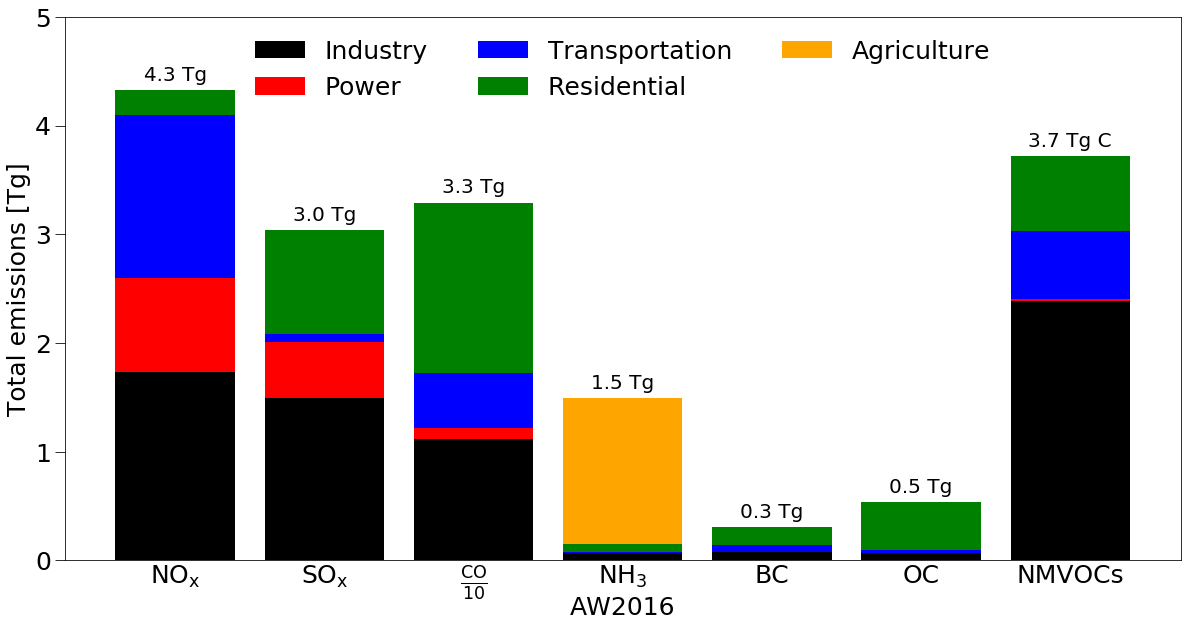

In [422]:
###########################################################################################################################
# make NCP emission barcharts

Industry = NCP_emissions.iloc[0,:]
Power    = NCP_emissions.iloc[1,:]
Transportation = NCP_emissions.iloc[2,:]
Residential = NCP_emissions.iloc[3,:]
Agriculture = NCP_emissions.iloc[4,:]


# plot layout
N = 7              # number of columns
ind = np.arange(N)  # locations for each bar on the x axis
width = 5           # width of the bars: can also be len(x) sequence

# make the plot
fig = plt.figure(figsize=(20,10))
sector1 = plt.bar(ind,Industry,color='black')
sector2 = plt.bar(ind,Power,bottom=Industry,color='red')
sector3 = plt.bar(ind,Transportation,bottom=(Power+Industry),color='blue')
sector4 = plt.bar(ind,Residential,bottom=(Power+Industry+Transportation),color='green')
sector5 = plt.bar(ind,Agriculture,bottom=(Power+Industry+Transportation+Residential),color='orange')

# fix x 
plt.xticks(ind,('NO$_\mathregular{x}$','SO$_\mathregular{x}$',r'$\mathregular{\frac{CO}{10}}$','NH$_\mathregular{3}$',
                'BC','OC','NMVOCs',))
plt.tick_params(axis='x', labelsize=25, length = 0)
plt.text(3,-0.5,'AW2016',fontsize=25,ha='center')

# fix y
plt.ylim(0,5)
plt.ylabel('Total emissions [Tg]',fontsize=25)
plt.tick_params(axis='y', labelsize=25, length = 10)

# legend
plt.legend((sector1[0],sector2[0],sector3[0],sector4[0],sector5[0]),('Industry', 'Power','Transportation','Residential','Agriculture'),
           loc='upper center', ncol=3,frameon=False,framealpha=1,borderpad=0.4, fontsize = 25)

# add text on top of each bar
height = []
for i in range(7):
      height.append(sector1[i].get_height()+sector2[i].get_height()+sector3[i].get_height()+sector4[i].get_height()+sector5[i].get_height())

plt.text(sector1[0].get_x() + sector1[0].get_width()/2.,1.0*height[0]+0.05,'4.3 Tg',ha='center',va='bottom',fontsize=20)
plt.text(sector1[1].get_x() + sector1[1].get_width()/2.,1.0*height[1]+0.05,'3.0 Tg',ha='center',va='bottom',fontsize=20)
plt.text(sector1[2].get_x() + sector1[2].get_width()/2.,1.0*height[2]+0.05,'3.3 Tg',ha='center',va='bottom',fontsize=20)
plt.text(sector1[3].get_x() + sector1[3].get_width()/2.,1.0*height[3]+0.05,'1.5 Tg',ha='center',va='bottom',fontsize=20)
plt.text(sector1[4].get_x() + sector1[4].get_width()/2.,1.0*height[4]+0.05,'0.3 Tg',ha='center',va='bottom',fontsize=20)
plt.text(sector1[5].get_x() + sector1[5].get_width()/2.,1.0*height[5]+0.05,'0.5 Tg',ha='center',va='bottom',fontsize=20)
plt.text(sector1[6].get_x() + sector1[6].get_width()/2.,1.0*height[6]+0.05,'3.7 Tg C',ha='center',va='bottom',fontsize=20)

# save the output
plt.show()

os.chdir("/rds/projects/2018/maraisea-glu-01/Study/Research_Data/BTH/geoschem")
fig.savefig('NCP_emissions_AW2016.png',dpi=300,bbox_inches='tight') 